In [1]:
import pandas as pd 
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
from math import sqrt

import itertools
#from pmdarima import auto_arima

#statsmodels

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

%matplotlib inline

In [2]:
crude_oil = pd.read_csv("data/crude_oil.csv")
gold = pd.read_csv("data/gold.csv")
dow_jones = pd.read_csv("data/dow_jones.csv")
fed_funds = pd.read_csv("data/fed_funds.csv")

crude_oil['Crude Oil'] = crude_oil['real']
crude_oil = crude_oil.drop(['real', 'nominal'], axis = 1)
crude_oil['date'] = pd.to_datetime(crude_oil['date'])
crude_oil.set_index('date', inplace = True)


gold['Gold'] = gold['real']
gold = gold.drop(['real', 'nominal'], axis = 1)
gold['date'] = pd.to_datetime(gold['date'])
gold.set_index('date', inplace = True)

dow_jones['Dow Jones'] = dow_jones['real']
dow_jones = dow_jones.drop(['real', 'nominal'], axis = 1)
dow_jones['date'] = pd.to_datetime(dow_jones['date'])
dow_jones.set_index('date', inplace = True)

fed_funds['date'] = fed_funds['DATE']
fed_funds['Fed Funds'] = fed_funds['FEDFUNDS']
fed_funds = fed_funds.drop(['DATE', 'FEDFUNDS'], axis = 1)
fed_funds['date'] = pd.to_datetime(fed_funds['date'])
fed_funds.set_index('date', inplace = True)

crude_oil

,Crude Oil
date,
1946-01-01,18.79
1946-02-01,18.89
1946-03-01,18.69
1946-04-01,20.18
1946-05-01,20.07
...,...
2022-03-01,101.98
2022-04-01,105.84
2022-05-01,114.67


In [3]:
occidental = pd.read_csv("data/OXY Historical Data.csv")
occidental['date'] = pd.to_datetime(occidental['Date'], format = "%b %y")
occidental['OXY Price'] = occidental['Price']
occidental = occidental.drop(['Date', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Price'], axis = 1)
occidental = occidental.set_index('date')
occidental

,OXY Price
date,
2022-07-01,59.52
2022-06-01,58.88
2022-05-01,69.31
2022-04-01,55.09
2022-03-01,56.74
...,...
1980-08-01,13.19
1980-07-01,12.59
1980-06-01,12.83


,Dow Jones,Gold,Crude Oil,Fed Funds,OXY Price
date,,,,,
1915-01-01,1636.27,557.10,NaN,NaN,NaN
1915-02-01,1608.23,562.68,NaN,NaN,NaN
1915-03-01,1796.01,568.36,NaN,NaN,NaN
1915-04-01,2098.13,562.68,NaN,NaN,NaN
1915-05-01,1881.39,557.10,NaN,NaN,NaN
...,...,...,...,...,...
2022-03-01,35267.88,1986.24,101.98,0.20,56.74
2022-04-01,33339.96,1932.73,105.84,0.33,55.09
2022-05-01,32990.12,1847.26,114.67,0.77,69.31


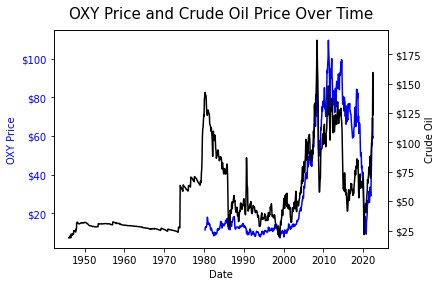

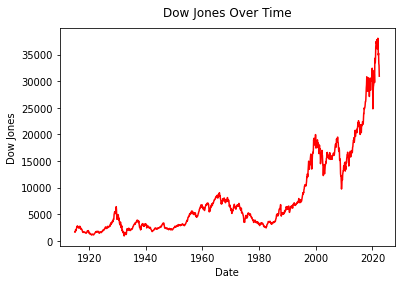

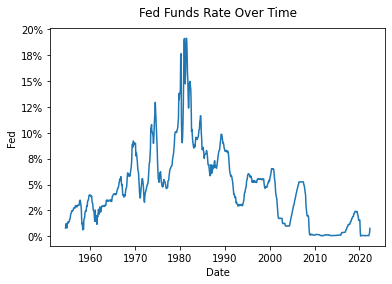

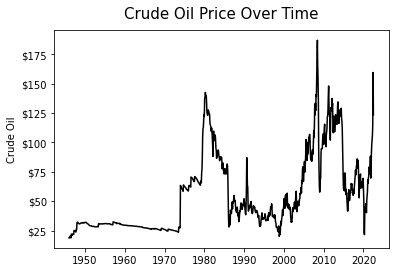

In [4]:
all_data = dow_jones.copy()
all_data['Gold'] = gold['Gold']
#all_data = all_data[400:]
#all_data['Crude Oil'] = crude_oil['Crude Oil']

all_data = pd.concat([all_data, crude_oil, fed_funds, occidental], axis=1)
#all_data = pd.concat([all_data, fed_funds], axis=1)
#all_data['Fed Funds'] = fed_funds['Fed Funds']


#all_data.set_index('date', inplace = True)


fig, ax1 = plt.subplots()
ax1.set_title('OXY Price and Crude Oil Price Over Time', pad = 12, fontsize = 15) 
color = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('OXY Price', color = color)
ax1.plot(all_data.index, all_data['OXY Price'], color = color)
ax1.tick_params(axis ='y', labelcolor = color)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'black'
ax2.set_ylabel('Crude Oil', color = color)
ax2.plot(all_data.index, all_data['Crude Oil'], color = color)
ax2.tick_params(axis ='y', labelcolor = color)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))


fig, ax3 = plt.subplots()
ax3.set_title('Dow Jones Over Time', pad = 12)
ax3.set_xlabel('Date')
color = 'red'
ax3.set_ylabel('Dow Jones')
ax3.plot(all_data.index, all_data['Dow Jones'], color = color)


fig, ax4 = plt.subplots()
ax4.set_title('Fed Funds Rate Over Time', pad = 12)
ax4.set_xlabel('Date')
ax4.set_ylabel('Fed')
ax4.plot(all_data.index, all_data['Fed Funds'])
ax4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}%'))

fig, ax5 = plt.subplots()
ax5.set_title('Crude Oil Price Over Time', pad = 12, fontsize = 15) 
color = 'black'
ax5.set_ylabel('Crude Oil', color = color)
ax5.plot(all_data.index, all_data['Crude Oil'], color = color)
ax5.tick_params(axis ='y', labelcolor = color)
ax5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
all_data



C:\Users\wjsdn\AppData\Local\Temp\ipykernel_2456\504848525.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(all_data.corr(), dtype=np.bool))


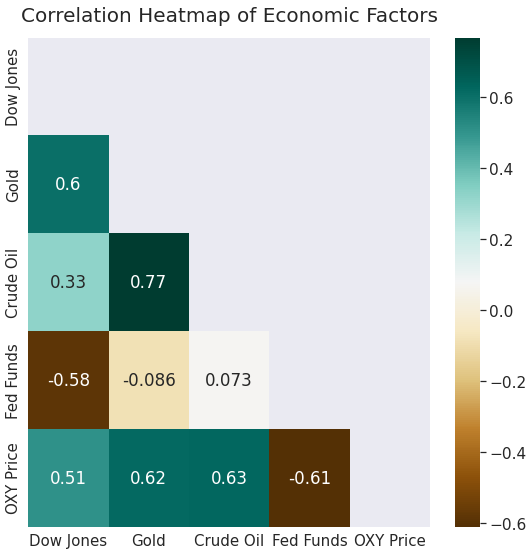

In [5]:
with sns.axes_style('darkgrid'):
    
    f, ax = plt.subplots(figsize=(9,9))
    
    mask = np.triu(np.ones_like(all_data.corr(), dtype=np.bool))
    
    plt.xticks(fontsize = 15)
    
    plt.yticks(fontsize = 15)
    
    sns.set(font_scale=1.4)
    
    heatmap = sns.heatmap(all_data.corr(), annot = True, mask = mask, cmap = "BrBG")
    
    heatmap.set_title("Correlation Heatmap of Economic Factors", fontdict={'fontsize': 20}, pad =16)

In [6]:
all_data['Crude Oil']

date
1915-01-01       NaN
1915-02-01       NaN
1915-03-01       NaN
1915-04-01       NaN
1915-05-01       NaN
               ...  
2022-03-01    101.98
2022-04-01    105.84
2022-05-01    114.67
2022-06-01    159.57
2022-07-01    123.71
Freq: MS, Name: Crude Oil, Length: 1291, dtype: float64

In [7]:
train_df = all_data['1990-07-01':'2021-05-01']
test_df = all_data['2021-05-01':'2022-07-01']

test_df

,Dow Jones,Gold,Crude Oil,Fed Funds,OXY Price
date,,,,,
2021-05-01,37498.98,2068.55,72.02,0.06,25.96
2021-06-01,37124.70,1906.24,79.05,0.08,31.27
2021-07-01,37415.89,1942.92,79.20,0.10,26.10
2021-08-01,37765.26,1939.27,73.16,0.09,25.69
2021-09-01,36077.62,1872.60,79.98,0.08,29.58
2021-10-01,37861.27,1885.58,88.33,0.08,33.53
2021-11-01,36276.87,1868.27,69.62,0.08,29.65
2021-12-01,38082.54,1916.37,78.82,0.08,28.99
2022-01-01,36537.13,1867.96,91.68,0.08,37.67


In [8]:
test_df_oil = test_df['Crude Oil']
test_df_oil = pd.DataFrame(test_df_oil)
test_df_oil

,Crude Oil
date,
2021-05-01,72.02
2021-06-01,79.05
2021-07-01,79.20
2021-08-01,73.16
2021-09-01,79.98
2021-10-01,88.33
2021-11-01,69.62
2021-12-01,78.82
2022-01-01,91.68


In [9]:
train_df_oil = train_df['Crude Oil']
train_df_oil = pd.DataFrame(train_df_oil)
train_df_oil

,Crude Oil
date,
1990-07-01,46.39
1990-08-01,60.68
1990-09-01,87.04
1990-10-01,77.12
1990-11-01,63.04
...,...
2021-01-01,58.31
2021-02-01,68.33
2021-03-01,65.31


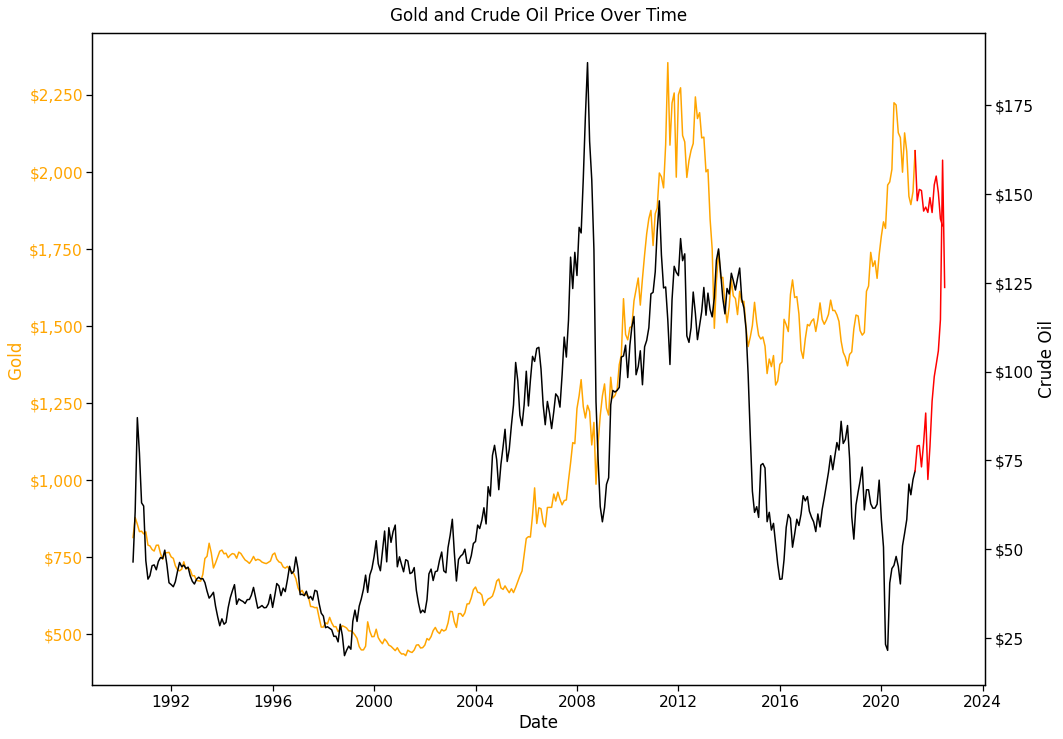

In [10]:
gold = pd.DataFrame()

fig, ax1 = plt.subplots(figsize=(16,12))
ax1.set_title('Gold and Crude Oil Price Over Time', pad = 12) 
color = 'orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold', color = color)
ax1.plot(train_df.index, train_df['Gold'], color = color)
ax1.plot(test_df.index, test_df['Gold'], color = 'red')
ax1.tick_params(axis ='y', labelcolor = color)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'black'
ax2.set_ylabel('Crude Oil', color = color)
ax2.plot(train_df.index, train_df['Crude Oil'], color = color)
ax2.plot(test_df.index, test_df['Crude Oil'], color = 'red')
ax2.tick_params(axis ='y', labelcolor = color)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

In [11]:
oil_train = train_df['Crude Oil']


oil_train_model = ARIMA(oil_train, order = (0,3,1))
oil_train_model_fit = oil_train_model.fit()
print(oil_train_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Crude Oil   No. Observations:                  371
Model:                 ARIMA(0, 3, 1)   Log Likelihood               -1332.617
Date:                Wed, 13 Jul 2022   AIC                           2669.234
Time:                        08:13:44   BIC                           2677.050
Sample:                    07-01-1990   HQIC                          2672.340
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      1.615     -0.619      0.536      -4.165       2.166
sigma2        80.5360    130.201      0.619      0.536    -174.653     335.725
Ljung-Box (L1) (Q):                  59.96   Jarque-

C:\Users\wjsdn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [12]:
oil_train_model_fit

In [13]:
predict = oil_train_model_fit.predict()
oil_train_predict = pd.DataFrame(predict)
oil_train_predict

,predicted_mean
date,
1990-07-01,0.000000
1990-08-01,92.781245
1990-09-01,74.383557
1990-10-01,125.463889
1990-11-01,55.097781
...,...
2021-01-01,57.930450
2021-02-01,62.151491
2021-03-01,78.338395


<AxesSubplot:xlabel='date'>

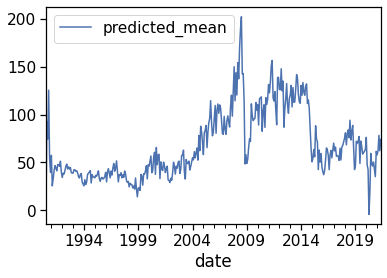

In [14]:
oil_train_predict.plot()

In [15]:
oil_fore = oil_train_model_fit.forecast(steps=100)
oil_fore = pd.DataFrame(oil_fore)
oil_fore

,predicted_mean
2021-06-01,74.387812
2021-07-01,76.723436
2021-08-01,79.026871
2021-09-01,81.298119
2021-10-01,83.537178
...,...
2029-05-01,152.552034
2029-06-01,151.829785
2029-07-01,151.075347
2029-08-01,150.288722


In [16]:
oil_fore.idxmax()

predicted_mean   2027-07-01
dtype: datetime64[ns]

In [17]:
oil_fore_error = oil_fore[:14]
oil_fore_error

,predicted_mean
2021-06-01,74.387812
2021-07-01,76.723436
2021-08-01,79.026871
2021-09-01,81.298119
2021-10-01,83.537178
2021-11-01,85.744049
2021-12-01,87.918732
2022-01-01,90.061227
2022-02-01,92.171534
2022-03-01,94.249652


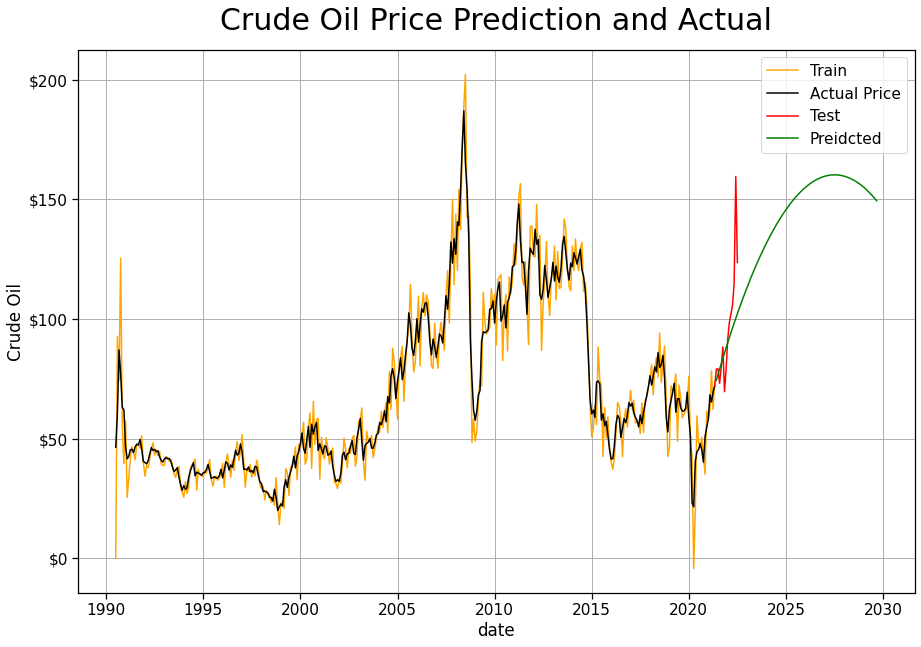

In [18]:
fig, ax2 = plt.subplots(figsize=(15, 10))

ax2.set_title('Crude Oil Price Prediction and Actual', pad = 20, fontsize = 30) 
color = 'black'
ax2.set_ylabel('Crude Oil', color = color)
ax2.plot(oil_train_predict.index, oil_train_predict['predicted_mean'], color = 'orange')
ax2.plot(train_df.index, train_df['Crude Oil'], color = color)
ax2.plot(test_df.index, test_df['Crude Oil'], color = 'red')
ax2.plot(oil_fore.index, oil_fore['predicted_mean'], color = 'green')

ax2.tick_params(axis ='y', labelcolor = color)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.legend(['Train', 'Actual Price', 'Test', 'Preidcted']);
ax2.set_xlabel('date')
plt.grid()

In [19]:
test_df_oil_error = test_df_oil[1:]
test_df_oil_error.mean()

Crude Oil    96.014286
dtype: float64

In [20]:
rms_test = sqrt(mean_squared_error(test_df_oil_error, oil_fore_error))
rms_test

18.645331606904584

In [21]:
rms_train = sqrt(mean_squared_error(train_df_oil, oil_train_predict))
rms_train

9.645492079222704

In [22]:
train_df_oil.mean()

Crude Oil    67.93442
dtype: float64

In [23]:
from prophet import Prophet

In [24]:
oil_df =all_data['2005-05-01':'2022-07-01']
oil_df['ds'] = oil_df.index
oil_df.rename(columns = {'Crude Oil' : 'y'}, inplace = True)
oil_df = oil_df.reindex(columns=['ds', 'y'])
oil_df

C:\Users\wjsdn\AppData\Local\Temp\ipykernel_2456\993763398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_df['ds'] = oil_df.index
C:\Users\wjsdn\AppData\Local\Temp\ipykernel_2456\993763398.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_df.rename(columns = {'Crude Oil' : 'y'}, inplace = True)


,ds,y
date,,
2005-05-01,2005-05-01,78.16
2005-06-01,2005-06-01,84.92
2005-07-01,2005-07-01,90.61
2005-08-01,2005-08-01,102.58
2005-09-01,2005-09-01,97.37
...,...,...
2022-03-01,2022-03-01,101.98
2022-04-01,2022-04-01,105.84
2022-05-01,2022-05-01,114.67


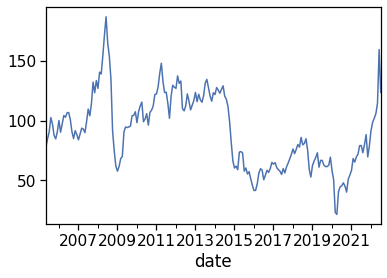

In [25]:
ax = oil_df['y'].plot()
plt.show()

In [26]:
oil_prophet = Prophet(changepoint_prior_scale = 1)
oil_prophet.fit(oil_df)

08:13:46 - cmdstanpy - INFO - Chain [1] start processing
08:13:46 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
forecast_time = 19
df_forecast = oil_prophet.make_future_dataframe(periods = forecast_time, freq = 'M')
df_forecast

,ds
0,2005-05-01
1,2005-06-01
2,2005-07-01
3,2005-08-01
4,2005-09-01
...,...
221,2023-09-30
222,2023-10-31
223,2023-11-30
224,2023-12-31


In [28]:
df_forecast = oil_prophet.predict(df_forecast)
df_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-05-01,86.586988,72.477376,109.141618,86.586988,86.586988,4.668387,4.668387,4.668387,4.668387,4.668387,4.668387,0.0,0.0,0.0,91.255375
1,2005-06-01,86.866336,80.167314,113.474814,86.866336,86.866336,9.987831,9.987831,9.987831,9.987831,9.987831,9.987831,0.0,0.0,0.0,96.854167
2,2005-07-01,87.136672,75.305653,111.666303,87.136672,87.136672,6.853261,6.853261,6.853261,6.853261,6.853261,6.853261,0.0,0.0,0.0,93.989933
3,2005-08-01,87.416020,74.929917,110.727294,87.416020,87.416020,5.215402,5.215402,5.215402,5.215402,5.215402,5.215402,0.0,0.0,0.0,92.631422
4,2005-09-01,87.695367,72.986423,109.677767,87.695367,87.695367,3.110068,3.110068,3.110068,3.110068,3.110068,3.110068,0.0,0.0,0.0,90.805435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,2023-09-30,100.096265,90.593658,148.781540,77.792173,121.900555,19.976464,19.976464,19.976464,19.976464,19.976464,19.976464,0.0,0.0,0.0,120.072730
222,2023-10-31,100.972340,77.998778,139.922586,76.056011,125.406529,7.105148,7.105148,7.105148,7.105148,7.105148,7.105148,0.0,0.0,0.0,108.077488
223,2023-11-30,101.820155,69.764856,134.351172,75.022894,128.660461,0.785069,0.785069,0.785069,0.785069,0.785069,0.785069,0.0,0.0,0.0,102.605224
224,2023-12-31,102.696229,52.732421,121.293835,73.276113,133.317428,-17.041895,-17.041895,-17.041895,-17.041895,-17.041895,-17.041895,0.0,0.0,0.0,85.654335


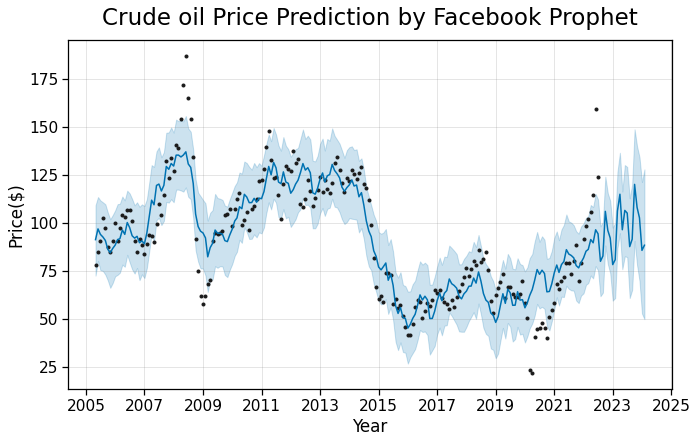

In [29]:
oil_prophet.plot(df_forecast, xlabel = 'Year', ylabel = 'Price($)')
#plt.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.title('Crude oil Price Prediction by Facebook Prophet', fontsize = 23, pad = 15);

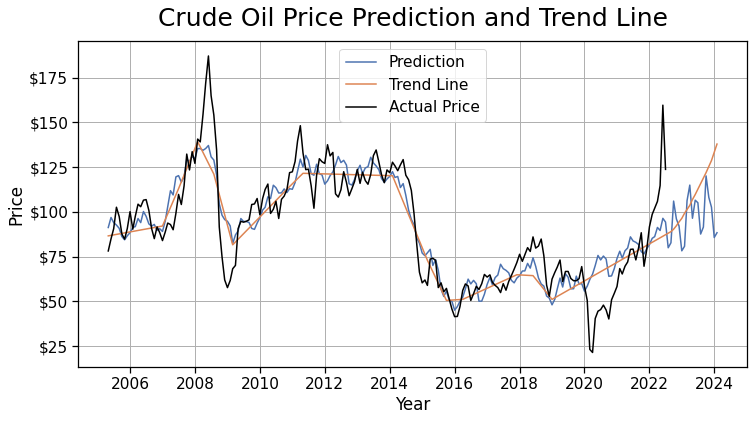

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

plt.plot(df_forecast['ds'], df_forecast['yhat'], label = 'Prediction')
plt.plot(df_forecast['ds'], df_forecast['trend_upper'], label = 'Trend Line' )
plt.plot(oil_df['ds'], oil_df['y'], label = 'Actual Price', color = 'black')
plt.legend()
plt.grid()
plt.ylabel('Price')
plt.xlabel('Year')
plt.title('Crude Oil Price Prediction and Trend Line', fontsize = 25, pad = 15);

In [39]:
df_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-05-01,86.586988,72.477376,109.141618,86.586988,86.586988,4.668387,4.668387,4.668387,4.668387,4.668387,4.668387,0.0,0.0,0.0,91.255375
1,2005-06-01,86.866336,80.167314,113.474814,86.866336,86.866336,9.987831,9.987831,9.987831,9.987831,9.987831,9.987831,0.0,0.0,0.0,96.854167
2,2005-07-01,87.136672,75.305653,111.666303,87.136672,87.136672,6.853261,6.853261,6.853261,6.853261,6.853261,6.853261,0.0,0.0,0.0,93.989933
3,2005-08-01,87.416020,74.929917,110.727294,87.416020,87.416020,5.215402,5.215402,5.215402,5.215402,5.215402,5.215402,0.0,0.0,0.0,92.631422
4,2005-09-01,87.695367,72.986423,109.677767,87.695367,87.695367,3.110068,3.110068,3.110068,3.110068,3.110068,3.110068,0.0,0.0,0.0,90.805435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,2023-09-30,100.096265,90.593658,148.781540,77.792173,121.900555,19.976464,19.976464,19.976464,19.976464,19.976464,19.976464,0.0,0.0,0.0,120.072730
222,2023-10-31,100.972340,77.998778,139.922586,76.056011,125.406529,7.105148,7.105148,7.105148,7.105148,7.105148,7.105148,0.0,0.0,0.0,108.077488
223,2023-11-30,101.820155,69.764856,134.351172,75.022894,128.660461,0.785069,0.785069,0.785069,0.785069,0.785069,0.785069,0.0,0.0,0.0,102.605224
224,2023-12-31,102.696229,52.732421,121.293835,73.276113,133.317428,-17.041895,-17.041895,-17.041895,-17.041895,-17.041895,-17.041895,0.0,0.0,0.0,85.654335


In [38]:
df_forecast_error = df_forecast[:207]
df_forecast_error

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-05-01,86.586988,72.477376,109.141618,86.586988,86.586988,4.668387,4.668387,4.668387,4.668387,4.668387,4.668387,0.0,0.0,0.0,91.255375
1,2005-06-01,86.866336,80.167314,113.474814,86.866336,86.866336,9.987831,9.987831,9.987831,9.987831,9.987831,9.987831,0.0,0.0,0.0,96.854167
2,2005-07-01,87.136672,75.305653,111.666303,87.136672,87.136672,6.853261,6.853261,6.853261,6.853261,6.853261,6.853261,0.0,0.0,0.0,93.989933
3,2005-08-01,87.416020,74.929917,110.727294,87.416020,87.416020,5.215402,5.215402,5.215402,5.215402,5.215402,5.215402,0.0,0.0,0.0,92.631422
4,2005-09-01,87.695367,72.986423,109.677767,87.695367,87.695367,3.110068,3.110068,3.110068,3.110068,3.110068,3.110068,0.0,0.0,0.0,90.805435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,2022-03-01,83.761709,68.596852,103.451008,83.761709,83.761709,2.407280,2.407280,2.407280,2.407280,2.407280,2.407280,0.0,0.0,0.0,86.168989
203,2022-04-01,84.637784,72.534559,109.321580,84.637784,84.637784,6.663959,6.663959,6.663959,6.663959,6.663959,6.663959,0.0,0.0,0.0,91.301743
204,2022-05-01,85.485598,71.028952,108.225560,85.485598,85.485598,4.116755,4.116755,4.116755,4.116755,4.116755,4.116755,0.0,0.0,0.0,89.602354
205,2022-06-01,86.361673,77.480865,115.082727,86.361673,86.361673,10.024304,10.024304,10.024304,10.024304,10.024304,10.024304,0.0,0.0,0.0,96.385978


In [40]:
facebook_rmse = sqrt(mean_squared_error(oil_df['y'], df_forecast_error['yhat']))
facebook_rmse

14.08660156768478